# Устранение пропусков в данных

**Проблема.** Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будет с ними работать. Даже корреляционная матрица не будет строиться корректно.

Существуют различные способы устранения пропусков в данных, которые связаны с удалением или заполнением пропусков.

## Загрузка и первичный анализ данных

Используем данные из соревнования [House Prices: Advanced Regression Techniques.](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# Будем использовать только обучающую выборку
hdata_loaded = pd.read_csv('data/houseprices.csv', sep=",")

In [3]:
hdata_loaded.shape

(1460, 81)

In [4]:
hdata = hdata_loaded

## Удаление пропущенных значений

**Допущение:** пропуски распределены случайным образом.

**Когда рекомендуется использовать?**
- Если пропущенных данных слишком много и возникает опасность нарушить распределение исходных данных при заполнении пропусков. Рекомендуется удалять признак (колонку) целиком.
- Если датасет большой и пропущенных данных относительно немного, то рекомендуется удалять строки, содержащие пропуски в данных.
- Под "немного" в идеальном случае понимается 5% от выборки.

**Преимущества:**
- Простота реализации.
- При случайном распределении пропусков сохраняются параметры распределения исходных данных.

**Недостатки:**
- Может быть удален большой фрагмент данных при неудачном распределении пропусков в нескольких столбцах.
- Если пропуски распределены не случайно, то можно удалить значимые данные.

In [5]:
list(zip(hdata.columns, [i for i in hdata.dtypes]))

[('Id', dtype('int64')),
 ('MSSubClass', dtype('int64')),
 ('MSZoning', dtype('O')),
 ('LotFrontage', dtype('float64')),
 ('LotArea', dtype('int64')),
 ('Street', dtype('O')),
 ('Alley', dtype('O')),
 ('LotShape', dtype('O')),
 ('LandContour', dtype('O')),
 ('Utilities', dtype('O')),
 ('LotConfig', dtype('O')),
 ('LandSlope', dtype('O')),
 ('Neighborhood', dtype('O')),
 ('Condition1', dtype('O')),
 ('Condition2', dtype('O')),
 ('BldgType', dtype('O')),
 ('HouseStyle', dtype('O')),
 ('OverallQual', dtype('int64')),
 ('OverallCond', dtype('int64')),
 ('YearBuilt', dtype('int64')),
 ('YearRemodAdd', dtype('int64')),
 ('RoofStyle', dtype('O')),
 ('RoofMatl', dtype('O')),
 ('Exterior1st', dtype('O')),
 ('Exterior2nd', dtype('O')),
 ('MasVnrType', dtype('O')),
 ('MasVnrArea', dtype('float64')),
 ('ExterQual', dtype('O')),
 ('ExterCond', dtype('O')),
 ('Foundation', dtype('O')),
 ('BsmtQual', dtype('O')),
 ('BsmtCond', dtype('O')),
 ('BsmtExposure', dtype('O')),
 ('BsmtFinType1', dtype('O')),

In [6]:
# Колонки с пропусками
hcols_with_na = [c for c in hdata.columns if hdata[c].isnull().sum() > 0]
hcols_with_na

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [7]:
hdata.shape

(1460, 81)

In [8]:
# Количество пропусков
[(c, hdata[c].isnull().sum()) for c in hcols_with_na]

[('LotFrontage', 259),
 ('Alley', 1369),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtExposure', 38),
 ('BsmtFinType1', 37),
 ('BsmtFinType2', 38),
 ('Electrical', 1),
 ('FireplaceQu', 690),
 ('GarageType', 81),
 ('GarageYrBlt', 81),
 ('GarageFinish', 81),
 ('GarageQual', 81),
 ('GarageCond', 81),
 ('PoolQC', 1453),
 ('Fence', 1179),
 ('MiscFeature', 1406)]

In [9]:
# Доля (процент) пропусков
[(c, hdata[c].isnull().mean()) for c in hcols_with_na]

[('LotFrontage', 0.1773972602739726),
 ('Alley', 0.9376712328767123),
 ('MasVnrType', 0.005479452054794521),
 ('MasVnrArea', 0.005479452054794521),
 ('BsmtQual', 0.025342465753424658),
 ('BsmtCond', 0.025342465753424658),
 ('BsmtExposure', 0.026027397260273973),
 ('BsmtFinType1', 0.025342465753424658),
 ('BsmtFinType2', 0.026027397260273973),
 ('Electrical', 0.0006849315068493151),
 ('FireplaceQu', 0.4726027397260274),
 ('GarageType', 0.05547945205479452),
 ('GarageYrBlt', 0.05547945205479452),
 ('GarageFinish', 0.05547945205479452),
 ('GarageQual', 0.05547945205479452),
 ('GarageCond', 0.05547945205479452),
 ('PoolQC', 0.9952054794520548),
 ('Fence', 0.8075342465753425),
 ('MiscFeature', 0.963013698630137)]

In [10]:
# Колонки для которых удаляются пропуски
hcols_with_na_temp = ['LotFrontage', 'GarageYrBlt', 'BsmtQual', 'MasVnrArea']

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [11]:
# Удаление пропусков
hdata_drop = hdata[hcols_with_na_temp].dropna()
hdata_drop.shape

(1097, 4)

In [12]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

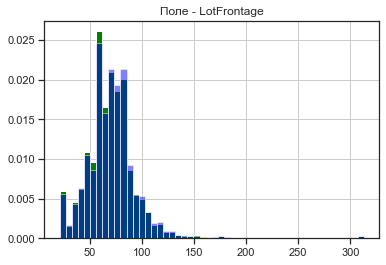

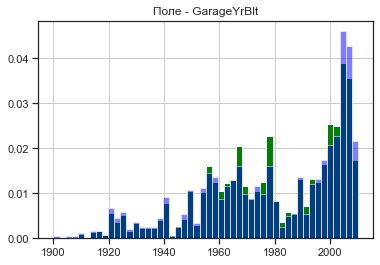

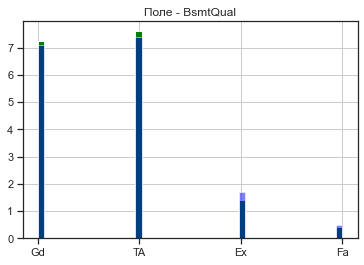

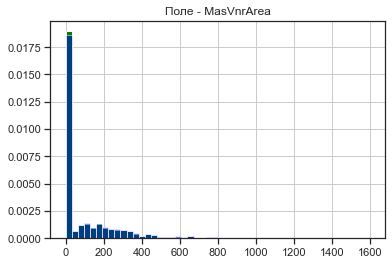

In [13]:
plot_hist_diff(hdata, hdata_drop, hcols_with_na_temp)

## Заполнение значений для одного признака

В этом случае данные которые находятся в соседних признаках  (колонках) не учитываются при заполнении.

**Заполнение (внедрение) значений или импьютация (imputation)** - это заполнение пропущенных значений их статистическими оценками.

**Для числовых признаков:**
- Заполнение [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F).
- Заполнение константой. *Полезно в случае "неслучайного" распределения пропусков.*
- Заполнение "хвостом распределения".

**Для категориальных признаков:**
- Заполнение наиболее распространенным значением категории (аналогом моды).
- Введение отдельного значения категории для пропущенных значений.

**Для числовых и категориальных признаков:**
- Добавления флага пропусков.
- Заполнение случайным значением признака. *Метод обычно применяют на больших выборках. Преимуществом является то, что он сохраняет дисперсию исходной выборки.*



### Заполнение [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F) и константой

**Для числовых признаков.**

В случае нормального распределения математическое ожидание, медиана и мода совпадают:

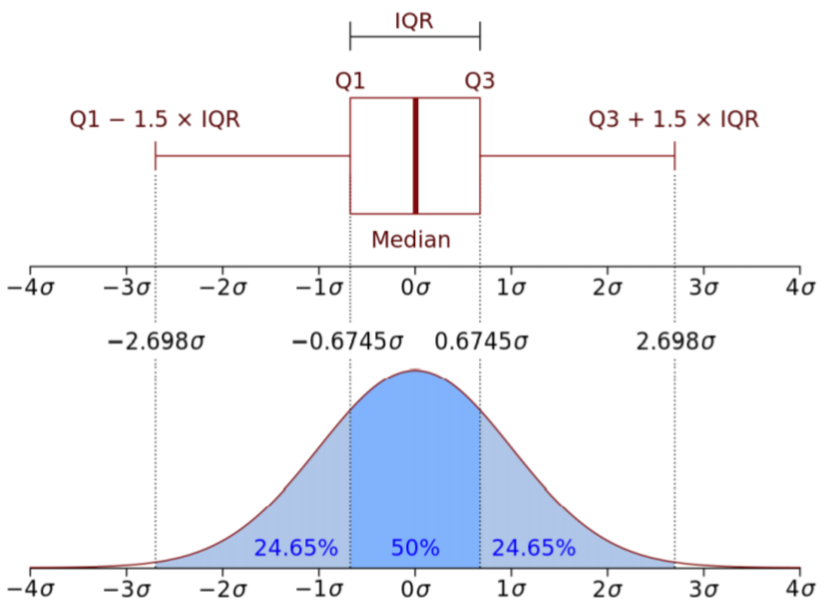

In [14]:
Image('img/normal_dist.png', width='50%')

Для ассиметричных распределений эти показатели различаются:

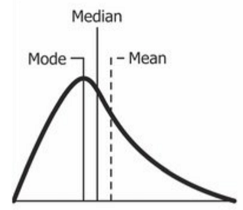

In [15]:
Image('img/center_skewed.png', width='30%')

**Когда рекомендуется использовать?**
- Если пропуски распределены случайным образом.
- В идеальном случае пропусков не более 5% от выборки.

**Какой показатель центра распределения лучше использовать?**
- Если распределение одномодальное, то лучше использовать моду, иначе математическое ожидание или медиану.
- Не существует однозначного предпочтения между математическим ожиданием или медианой. Но медиана более устойчива к выбросам в данных. 

Для внедрение) значений может быть использован класс [SimpleImputer.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

Для фильтрации пропущенных значений может быть использован класс [MissingIndicator.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.MissingIndicator.html)

In [16]:
# Пример работы MissingIndicator
temp_x1 = np.array([[np.nan, 1, 3], [4, 0, np.nan], [8, 1, 0]])
print('Исходный массив:')
print(temp_x1)
indicator = MissingIndicator()
temp_x1_transformed = indicator.fit_transform(temp_x1)
print('Маска пропущенных значений:')
print(temp_x1_transformed)

Исходный массив:
[[nan  1.  3.]
 [ 4.  0. nan]
 [ 8.  1.  0.]]
Маска пропущенных значений:
[[ True False]
 [False  True]
 [False False]]


In [17]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [18]:
all_data, filled_data, missed_data = impute_column(hdata, 'MasVnrArea', 'mean')
all_data

array([196.,   0., 162., ...,   0.,   0.,   0.])

In [19]:
filled_data

array([103.68526171, 103.68526171, 103.68526171, 103.68526171,
       103.68526171, 103.68526171, 103.68526171, 103.68526171])

In [20]:
missed_data

array([nan, nan, nan, nan, nan, nan, nan, nan])

In [21]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

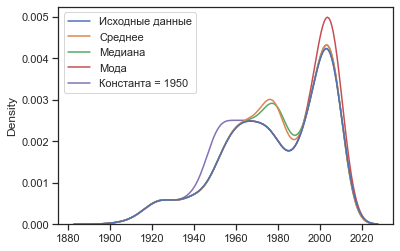

In [22]:
research_impute_numeric_column(hdata, 'GarageYrBlt', 1950)

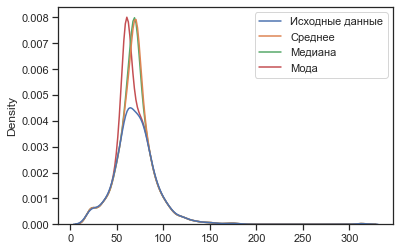

In [23]:
research_impute_numeric_column(hdata, 'LotFrontage')

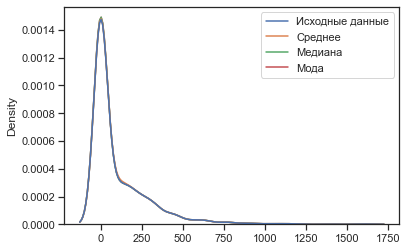

In [24]:
research_impute_numeric_column(hdata, 'MasVnrArea')

### Заполнение "хвостом распределения"

**Для числовых признаков.**

**Допущение:** пропуски распределены НЕ случайным образом. Мы хотим выделить пропущенные значения из остальных значений.

**Преимущества:**
- Простота реализации.
- Выделяет пропущенные значения из остальных значений.

**Недостатки:**
- Нарушение параметров исходного распределения.
- Поскольку значения на краю распределения фактически являются аномалиями (выбросами), то данный подход может пересекаться с алгоритмами поиска аномалий.

**Как вычислить "хвост распределения"?**

Если распределение данных признака $f$ напоминает нормальное:

$$ extreme\_value = mean(f) + 3 \cdot std(f) $$

Для ассиметричного распределения:

$$ IQR = Q3-Q1 $$

$IQR -$ interquartile range.

$$ extreme\_value = Q3 + K \cdot IQR $$

Значение $K$ обычно выбирается равным $1,5$. Но для экстремальных выбросов выбирают $K=3$.



In [25]:
# Похоже на нормальное
LotFrontage_ev = hdata['LotFrontage'].mean() + 3*hdata['LotFrontage'].std()
LotFrontage_ev

142.9042136914762

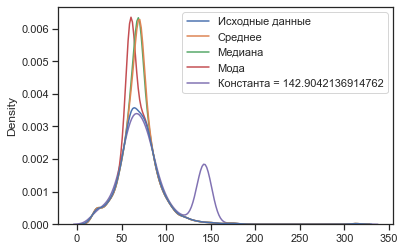

In [26]:
research_impute_numeric_column(hdata, 'LotFrontage', LotFrontage_ev)

In [27]:
# Ассиметричное
IQR = hdata['MasVnrArea'].quantile(0.75) - hdata['MasVnrArea'].quantile(0.25)
MasVnrArea_ev1 = hdata['MasVnrArea'].quantile(0.75) + 3*IQR
print('IQR={}, extreme_value={}'.format(IQR, MasVnrArea_ev1))

IQR=166.0, extreme_value=664.0


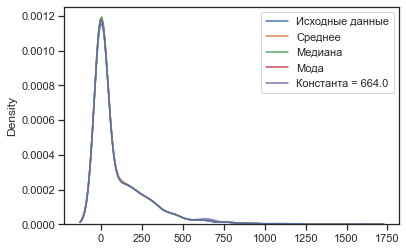

In [28]:
research_impute_numeric_column(hdata, 'MasVnrArea', MasVnrArea_ev1)

In [29]:
MasVnrArea_ev2 = hdata['MasVnrArea'].quantile(0.75) + 1.5*IQR
print('IQR={}, extreme_value={}'.format(IQR, MasVnrArea_ev2))

IQR=166.0, extreme_value=415.0


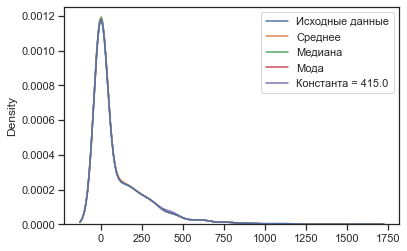

In [30]:
research_impute_numeric_column(hdata, 'MasVnrArea', MasVnrArea_ev2)

In [31]:
IQR_lf = hdata['LotFrontage'].quantile(0.75) - hdata['LotFrontage'].quantile(0.25)
LotFrontage_ev1 = hdata['LotFrontage'].quantile(0.75) + 1.5*IQR_lf
LotFrontage_ev2 = hdata['LotFrontage'].quantile(0.75) + 3*IQR_lf

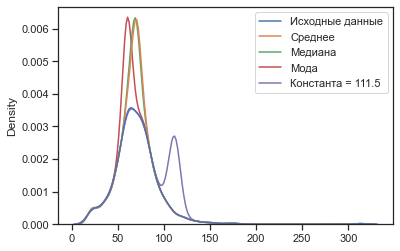

In [32]:
research_impute_numeric_column(hdata, 'LotFrontage', LotFrontage_ev1)

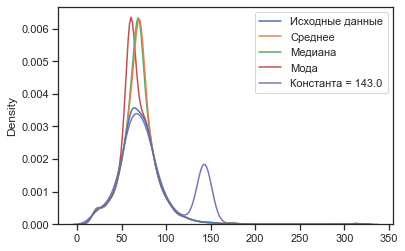

In [33]:
research_impute_numeric_column(hdata, 'LotFrontage', LotFrontage_ev2)

### Заполнение наиболее распространенным значением категории

**Для категориальных признаков.**

**Допущение:** пропуски распределены случайным образом. Заполнение пропусков наиболее распространенным значением категории в наименьшей степени повлияет на исходное распределение.

In [34]:
hdata_cat_cols = ['GarageType', 'PoolQC', 'Fence']
hdata_cat_new = hdata[hdata_cat_cols].copy() 

In [35]:
GarageType_cat_new_temp, _, _ = impute_column(hdata_cat_new, 'GarageType', 'most_frequent')
PoolQC_cat_new_temp, _, _ = impute_column(hdata_cat_new, 'PoolQC', 'most_frequent')
Fence_cat_new_temp, _, _ = impute_column(hdata_cat_new, 'Fence', 'most_frequent')

In [36]:
hdata_cat_new['GarageType'] = GarageType_cat_new_temp
hdata_cat_new['PoolQC'] = PoolQC_cat_new_temp
hdata_cat_new['Fence'] = Fence_cat_new_temp

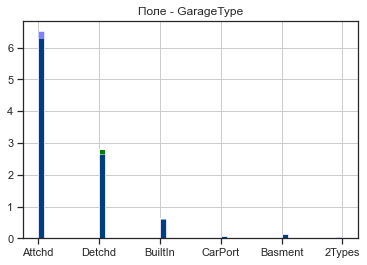

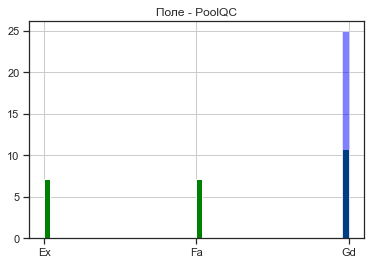

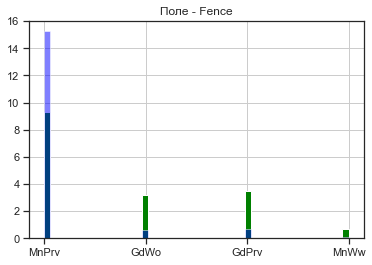

In [37]:
plot_hist_diff(hdata, hdata_cat_new, hdata_cat_cols)

### Введение отдельного значения категории для пропущенных значений

**Для категориальных признаков.**

**Основное преимущество подхода** состоит в том, что не дается никаких предположений о распределении  пропущенных значений.

In [38]:
hdata_cat_na = hdata[hdata_cat_cols].copy()

In [39]:
GarageType_cat_na_temp, _, _ = impute_column(hdata_cat_na, 'GarageType', 'constant', fill_value_param='NA')
PoolQC_cat_na_temp, _, _ = impute_column(hdata_cat_na, 'PoolQC', 'constant', fill_value_param='NA')
Fence_cat_na_temp, _, _ = impute_column(hdata_cat_na, 'Fence', 'constant', fill_value_param='NA')

In [40]:
hdata_cat_na['GarageType'] = GarageType_cat_na_temp
hdata_cat_na['PoolQC'] = PoolQC_cat_na_temp
hdata_cat_na['Fence'] = Fence_cat_na_temp

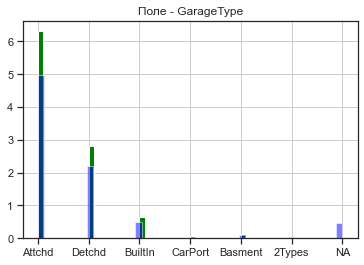

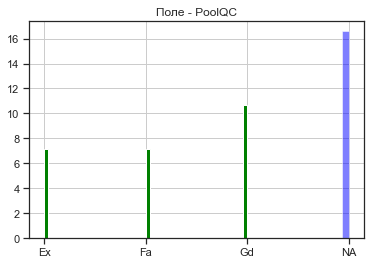

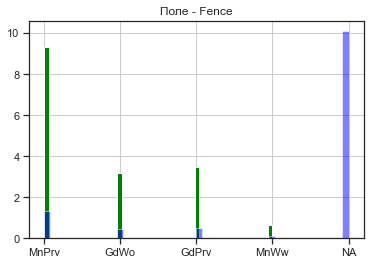

In [41]:
plot_hist_diff(hdata, hdata_cat_na, hdata_cat_cols)

### Добавления флага пропусков

**Для любых признаков.**

Для каждой колонки данных вводится дополнительная бинарная колонка, в которой пустым значениям признака соответствует 1.

**Преимущества:**
- Модель получает дополнительную информацию о том, насколько мы уверены в наших данных. Особенно хорошо этот подход работает для деревьев решений и производных моделей.

**Недостатки:**
- Расширяется признаковое пространство.
- Заполнять пропуски для исходных колонок все равно необходимо.
- Флаги для разных колонок могут сильно коррелировать между собой.

In [42]:
hdata_mis = hdata[['PoolQC']].copy()
hdata_mis.head()

,PoolQC
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [43]:
indicator = MissingIndicator()
PoolQC_missing = indicator.fit_transform(hdata_mis[['PoolQC']])
PoolQC_missing

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [44]:
PoolQC_missing_int = [1 if i==True else 0 for i in PoolQC_missing]
PoolQC_missing_int[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [45]:
hdata_mis['PoolQC_missing'] = PoolQC_missing_int
hdata_mis.head()

,PoolQC,PoolQC_missing
0,NaN,1
1,NaN,1
2,NaN,1
3,NaN,1
4,NaN,1


## Заполнение значений для нескольких признаков

В этом случае данные которые находятся в соседних признаках (колонках) учитываются при заполнении.

Идея состоит в том, что признаки могут зависеть между собой и такие зависимости необходимо использовать при заполнении пропусков.

В этом случае мы решаем отдельную задачу машинного обучения, рассматривая пропущенный признак как целевой (y), а остальные признаки как исходные (X).

Для решения задачи можно использовать различные методы машинного обучения. На практике чаще всего используется **метод ближайших соседей**.

Также проблема состоит в том, что практически все признаки могут содержать пропуски и для их заполнения другие признаки необходимо предварительно импьютировать известными методами. (возникает подобие циклических ссылок).

Для решения этой задачи используется метод 
**MICE (multivariate Imputation of Chained Equations)**. Существует расширение этого метода **MissForest** в котором используется случайный лес.

### Импьютация с использованием метода  ближайших соседей

Используется класс [KNNImputer.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

In [46]:
knnimpute_cols = [
    'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
    'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
    'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
    'WoodDeckSF',  'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold',
    'SalePrice'
]

In [47]:
knnimpute_hdata = hdata[knnimpute_cols].copy()
knnimpute_hdata.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [48]:
# Признаки с пропусками
knnimpute_hdata.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [49]:
knnimputer = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
)
knnimpute_hdata_imputed_temp = knnimputer.fit_transform(knnimpute_hdata)
knnimpute_hdata_imputed = pd.DataFrame(knnimpute_hdata_imputed_temp, columns=knnimpute_hdata.columns)
knnimpute_hdata_imputed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


In [50]:
# Пропуски заполнены
knnimpute_hdata_imputed.isnull().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
SalePrice        0
dtype: int64

<AxesSubplot:ylabel='Density'>

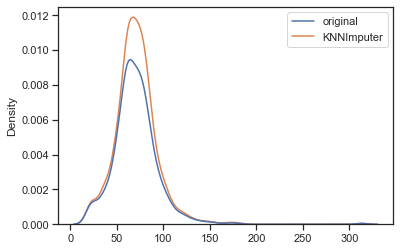

In [51]:
LotFrontage_df = pd.DataFrame({'original': knnimpute_hdata['LotFrontage'].values})
LotFrontage_df['KNNImputer'] = knnimpute_hdata_imputed['LotFrontage']
sns.kdeplot(data=LotFrontage_df)

<AxesSubplot:ylabel='Density'>

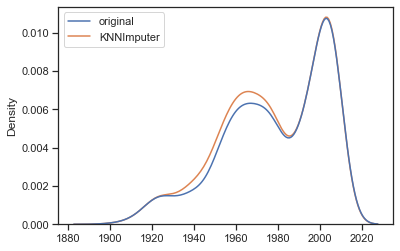

In [52]:
GarageYrBlt_df = pd.DataFrame({'original': knnimpute_hdata['GarageYrBlt'].values})
GarageYrBlt_df['KNNImputer'] = knnimpute_hdata_imputed['GarageYrBlt']
sns.kdeplot(data=GarageYrBlt_df)

#### Подбор гиперпараметров

Так как для импьютации используется модель KNN, то возникает необходимость подбора гиперпараметров. В этом случае необходимо создать полный пайплайн машинного обучения и оптимизировать параметры всего пайплайна.

In [53]:
pipe = Pipeline(steps=[
    ('imputer', KNNImputer(
        n_neighbors=5,
        weights='distance',
        add_indicator=False)),
    ('scaler', StandardScaler()),
    ('regressor', Lasso(max_iter=2000)),
])

In [54]:
param_grid = {
    'imputer__n_neighbors': [3,5,10],
    'imputer__weights': ['uniform', 'distance'],
    'imputer__add_indicator': [True, False],
    'regressor__alpha': [10, 100, 200],
}

In [55]:
grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='r2')

In [56]:
grid_search.fit(knnimpute_hdata, hdata['SalePrice'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        KNNImputer(weights='distance')),
                                       ('scaler', StandardScaler()),
                                       ('regressor', Lasso(max_iter=2000))]),
             n_jobs=-1,
             param_grid={'imputer__add_indicator': [True, False],
                         'imputer__n_neighbors': [3, 5, 10],
                         'imputer__weights': ['uniform', 'distance'],
                         'regressor__alpha': [10, 100, 200]},
             scoring='r2')

In [57]:
grid_search.best_params_

{'imputer__add_indicator': True,
 'imputer__n_neighbors': 3,
 'imputer__weights': 'uniform',
 'regressor__alpha': 10}

In [58]:
knnimputer2 = KNNImputer(
    n_neighbors=5, 
    weights='distance', 
    metric='nan_euclidean', 
    add_indicator=False, 
)
knnimpute_hdata_imputed_temp2 = knnimputer2.fit_transform(knnimpute_hdata)
knnimpute_hdata_imputed2 = pd.DataFrame(knnimpute_hdata_imputed_temp2, columns=knnimpute_hdata.columns)
knnimpute_hdata_imputed2.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


<AxesSubplot:ylabel='Density'>

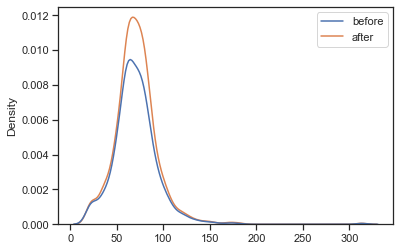

In [59]:
LotFrontage_df2 = pd.DataFrame({'before': knnimpute_hdata['LotFrontage'].values})
LotFrontage_df2['after'] = knnimpute_hdata_imputed2['LotFrontage']
sns.kdeplot(data=LotFrontage_df2)

<AxesSubplot:ylabel='Density'>

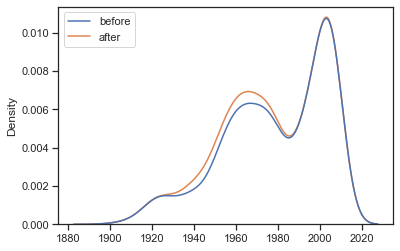

In [60]:
GarageYrBlt_df2 = pd.DataFrame({'before': knnimpute_hdata['GarageYrBlt'].values})
GarageYrBlt_df2['after'] = knnimpute_hdata_imputed2['GarageYrBlt']
sns.kdeplot(data=GarageYrBlt_df2)

### Метод  MICE (multivariate Imputation of Chained Equations)

Описание метода и его реализация в пакете [statsmodels.](https://www.statsmodels.org/stable/imputation.html)

**Основные шаги метода:**
1. Используем произвольную импьютацию для всех колонок (например, для числовых колонок - средним значением).
1. Для первой колонки подставляем обратно пустые значения.
1. Пропущенные значения в первой колонке предсказываются с помощью модели машинного обучения  на основе остальных значений.
1. Предсказанные значения подставляются в первую колонку.
1. Действия выше выполняются в цикле для всех колонок.
1. Действия выше выполняются заданное количество раз. Предполагается что на каждой итерации мы постепенно уточняем значения, соответствующие пропускам.


Рассмотрим реализацию [MissForest](https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3) с использованием [IterativeImputer.](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)

In [61]:
imputer_missForest = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=10, random_state=0),
    max_iter=10,
    random_state=0)

In [62]:
%%time
missForest_hdata_imputed_temp = imputer_missForest.fit_transform(knnimpute_hdata)

Wall time: 4.96 s


In [63]:
missForest_hdata_imputed = pd.DataFrame(missForest_hdata_imputed_temp, columns=knnimpute_hdata.columns)
missForest_hdata_imputed.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,0.0,61.0,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,208500.0
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,298.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,181500.0
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,223500.0
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,0.0,35.0,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,140000.0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,192.0,84.0,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,250000.0


<AxesSubplot:ylabel='Density'>

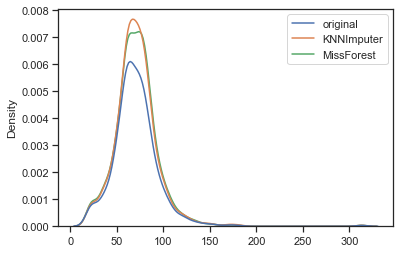

In [64]:
LotFrontage_df['MissForest'] = missForest_hdata_imputed['LotFrontage']
sns.kdeplot(data=LotFrontage_df)

<AxesSubplot:ylabel='Density'>

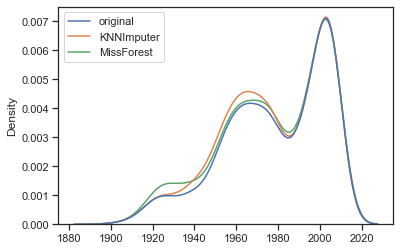

In [65]:
GarageYrBlt_df['MissForest'] = missForest_hdata_imputed['GarageYrBlt']
sns.kdeplot(data=GarageYrBlt_df)

Методы KNNImputer и MissForest также реализованы в библиотеке [missingpy.](https://github.com/epsilon-machine/missingpy)